# **Melanoma Skin Cancer Detection via Image**





<!-- #### **Project ELG 6131. Medical Diagnostic Engineering** -->

Steven Wilson<br>
MASc in Biomedical Engineering<br>
University of Ottawa <br>


---

The project aims to develop a machine learning model to enhance early detection of
melanoma, a serious form of skin cancer.

### **Contextual Background**

**Melanoma** is a type of cancer that starts in the cells that produce melanin, which are called
melanocytes. This cancer occurs when a melanocyte grows uncontrollably and turns into a
tumor. [1] Melanoma is **less common** than other types of cancers, however, it is the **most
serious type of skin cancer** and is much more likely to spread to other parts of the body if not
found and treated. [2]

Identifying a potential skin cancer is not easy and not all melanomas
follow the same rules. Melanomas have different forms and may not display the typical
warning signs; thus, early detection is important.

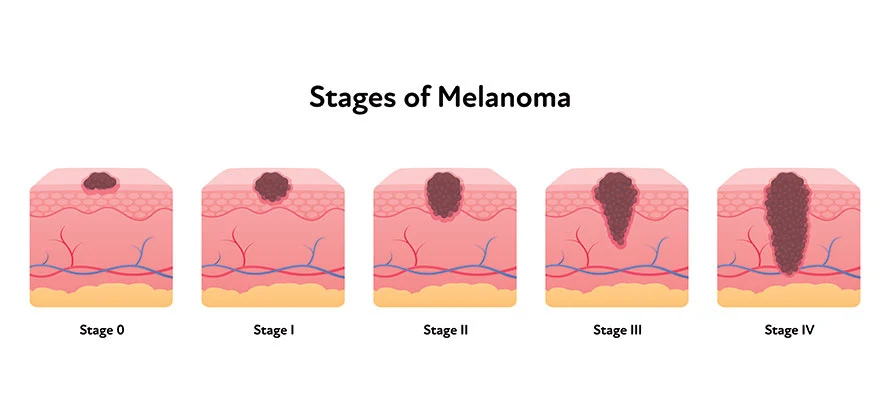

### **Implementation**

##### **Imports**

In [ ]:
# Package installation
!pip install tensorflow
!pip install Augmentor

# Imports
import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import Augmentor

##### **Loading the Dataset**

The dataset **Skin Cancer ISIC** is available on Kaggle and contains images of malignant and benign oncological diseases, which were formed from The International Skin Imaging Collaboration (ISIC).

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# unzip the skin cancer dataset that was uploaded to Google Drive as a zip
!unzip /content/gdrive/MyDrive/skin_cancer_dataset.zip -d /content/data  > /dev/null # remove > /dev/null if you want to see loading output
!mv "/content/data/Skin cancer ISIC The International Skin Imaging Collaboration" "/content/data/skin_cancer_dataset"
print("Files at /content/data : ")
!ls /content/data
# !ls -l /content/data/skin_cancer_dataset/Train/



Files at /content/data : 
skin_cancer_dataset


##### **Data Partioning**

In [ ]:
# separating the dataset into the predefined training/testing folders
training_data = Path("/content/data/skin_cancer_dataset/Train/")
testing_data = Path("/content/data/skin_cancer_dataset/Test/")

print("Training dataset size: ", len(list(training_data.glob('*/*.jpg'))))
print("Testing dataset size: ", len(list(testing_data.glob('*/*.jpg'))))

Training dataset size:  2239
Testing dataset size:  118


##### **Understanding the Data**

`image_dataset_from_directory()` will return a tf.data.Dataset that yields batches of images from the subdirectories

`label_mode` is categorical, the labels are a `float32` tensor of shape:

  * `batch_size`
  * `num_classes`

Which represent a one-hot enconding of the class index.


Found 2239 files belonging to 9 classes.
['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


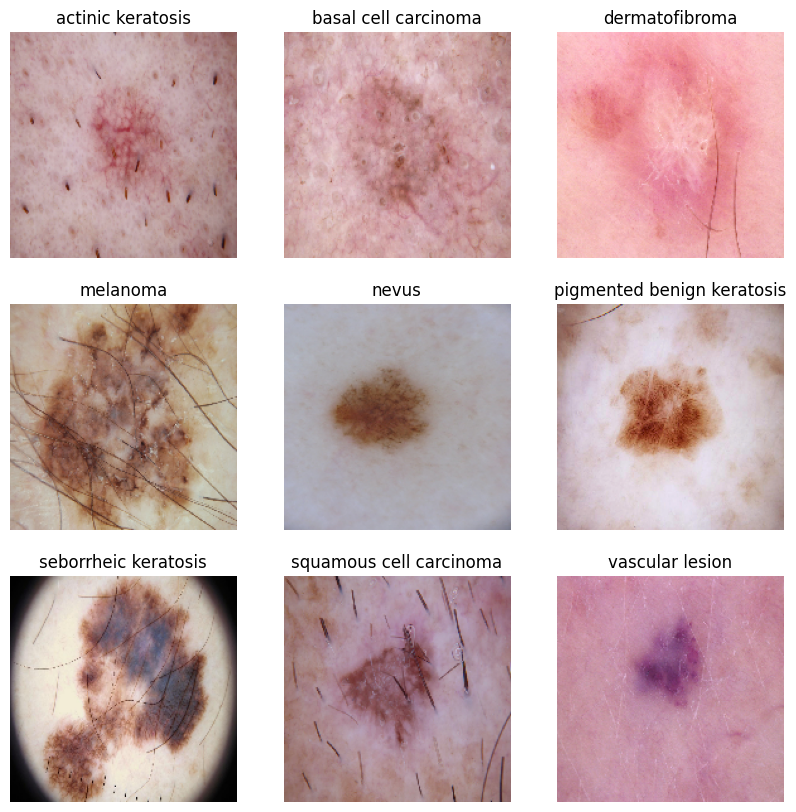

In [ ]:
# Load images from the directory with TensorFlow
image_dataset = image_dataset_from_directory(
    training_data,
    batch_size=32,
    image_size=(180, 180),
    label_mode='categorical',
    seed=123
)

#all the classes of Skin Cancer
class_names = image_dataset.class_names
print(class_names)

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(training_data)+'/'+c+'/'+x,os.listdir(str(training_data)+'/'+c)))

#Visualize image
plt.figure(figsize=(10,10))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

###### **Overview of Common and Serious Skin Lesions and Cancers**

The dataset consists of 2,347 images of malignant and benign oncological diseases. The images are sorted and classified among 9 categories:

* **Actinic Keratosis:** A rough, scaly patch on the skin caused by years of sun exposure.

* **Basal Cell Carcinoma:** A type of skin cancer that is most common but least aggressive, originating in the basal cells.

* **Dermatofibroma:** A common benign skin nodule that usually develops on the lower legs and is firm to touch.

* **Melanoma:** The most serious type of skin cancer, which forms from pigment-producing skin cells.

* **Nevus:** Commonly known as a mole, it is a benign proliferation of skin cells that produce pigment.

* **Pigmented Benign Keratosis:** A benign skin growth that appears as a small, dark spot, which can be mistaken for skin cancer but is harmless.

* **Seborrheic Keratosis:** A benign skin growth that looks like a waxy or wart-like bump, often appearing in middle age or later.

* **Squamous Cell Carcinoma:** A form of skin cancer that develops in the squamous cells, which compose most of the skin's upper layers (epidermis).

* **Vascular Lesion:** A generic term for lesions formed by blood vessels that may appear as red or purple patches on the skin, often benign.



**Class Distribution**

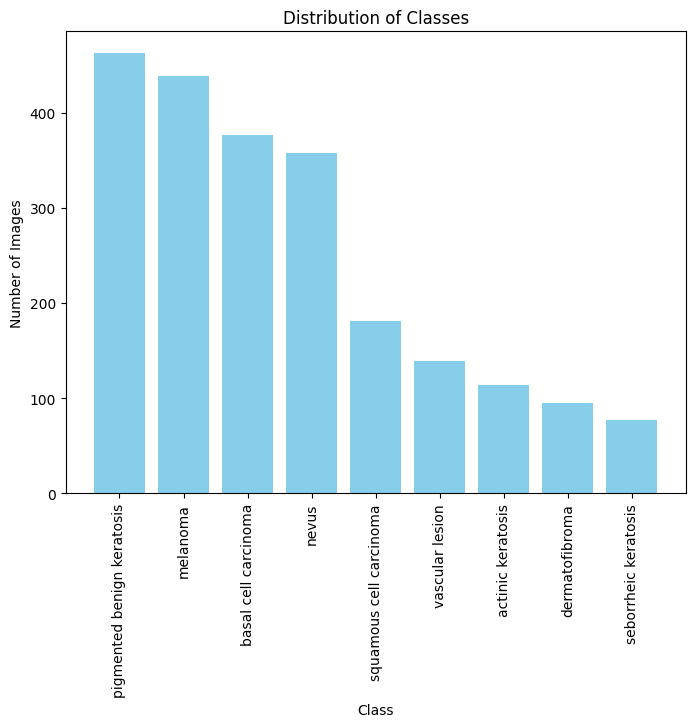

In [ ]:
def class_distribution_count(directory, check_output=False):
    """
    Counts the number of images in each class within a directory and returns a DataFrame
    listing each class with its corresponding image count.
    """
    data = []

    # Create a Path object for the directory
    dir_path = Path(directory)

    # Iterate over each item in the directory
    for subdir in dir_path.iterdir():
        # Update the path to include 'output' if check_output is True
        if subdir.is_dir():  # Check if the item is a directory
            target_dir = subdir / 'output' if check_output else subdir

            # Check again if the target_dir is a directory, especially important for the 'output' case
            if target_dir.is_dir():
                # List all files in the subdirectory and count them
                file_count = sum(1 for item in target_dir.iterdir() if item.is_file())
                # Append the class name and file count to the list
                data.append((subdir.name, file_count))
            else:
                data.append((subdir.name, 0))  # If no 'output' directory or no files

    # Create a DataFrame from the collected data
    df = pd.DataFrame(data, columns=['Class', 'No. of Image'])

    # Plot class distribution if needed
    plot_class_distribution(df)

    return df

def plot_class_distribution(df):
    # Sorting the DataFrame by the number of images to better visualize the distribution
    df_sorted = df.sort_values('No. of Image', ascending=False)

    plt.figure(figsize=(8, 6))  # Set the figure size for better readability
    plt.bar(df_sorted['Class'], df_sorted['No. of Image'], color='skyblue')  # Create a bar chart
    plt.xlabel('Class')  # Set the x-axis label
    plt.ylabel('Number of Images')  # Set the y-axis label
    plt.title('Distribution of Classes')  # Set the title of the chart
    plt.xticks(rotation=90)  # Rotate class labels for better visibility if they are long
    plt.show()  # Display the plot

# DataFrame for class distribution ['Class', 'No. of Images']
df = class_distribution_count(training_data) # For Training Data


The subsets are divided into varying numbers of images. **Pigmented benign keratosis** and **Melanoma** have the highest number of images. **Seborrheic keratosis** and **Dermatofibroma** have significantly fewer images compared to the biggest classes.

##### **Data Balancing**

There is a noticeable **class imbalance**. The images are unevenly distributed, with some classes having significantly more samples than others.

In [ ]:
for c in class_names:
  p = Augmentor.Pipeline(str(training_data)+'/'+c)
  p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
  p.sample(1200) # Adjusts each class to have 500 samples

Initialised with 114 image(s) found.
Output directory set to /content/data/skin_cancer_dataset/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7804C134EA50>: 100%|██████████| 1200/1200 [00:41<00:00, 28.68 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/data/skin_cancer_dataset/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7804C10E0610>: 100%|██████████| 1200/1200 [00:45<00:00, 26.66 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/data/skin_cancer_dataset/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7804C103C790>: 100%|██████████| 1200/1200 [00:40<00:00, 29.65 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/data/skin_cancer_dataset/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x78055FF8E190>: 100%|██████████| 1200/1200 [03:27<00:00,  5.80 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/data/skin_cancer_dataset/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7804C103CF10>: 100%|██████████| 1200/1200 [03:15<00:00,  6.13 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/data/skin_cancer_dataset/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7804C1117450>: 100%|██████████| 1200/1200 [00:41<00:00, 28.75 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/data/skin_cancer_dataset/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7804C1427D10>: 100%|██████████| 1200/1200 [01:39<00:00, 12.07 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/data/skin_cancer_dataset/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7804C4ED84D0>: 100%|██████████| 1200/1200 [00:41<00:00, 28.90 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/data/skin_cancer_dataset/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7804C135A150>: 100%|██████████| 1200/1200 [00:40<00:00, 29.35 Samples/s]


Total number of images generated by Augmentor:  10800


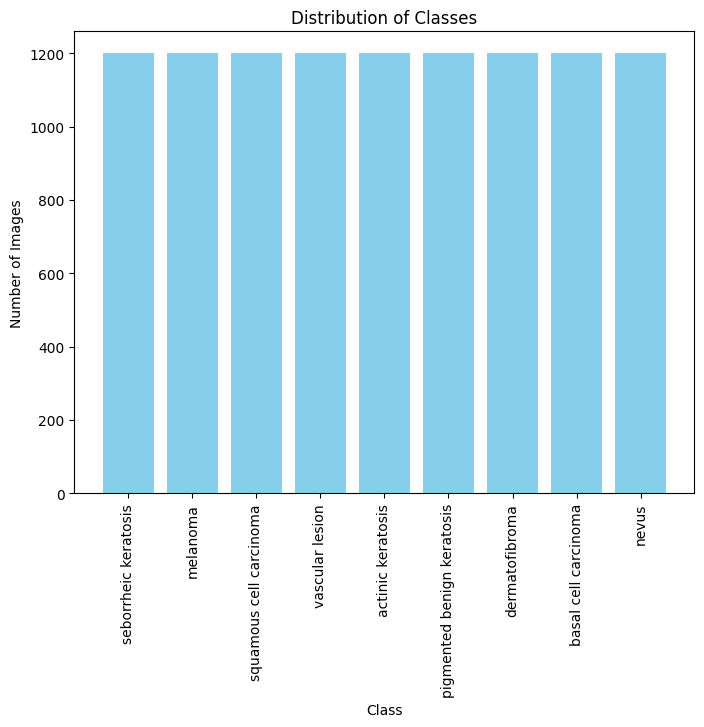

In [ ]:

#Count total number of image generated by Augmentor.
image_count_train = len(list(training_data.glob('*/output/*.jpg')))
print("Total number of images generated by Augmentor: ", image_count_train)

df = class_distribution_count(training_data, True) # For Training Data

##### **Training and Testing**

In [ ]:
# Data for training the model
print('Testing Dataset: ')
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  training_data,
  batch_size=32,
  image_size=(180, 180),
  label_mode='categorical',
  validation_split=0.2,
  subset="training",
  seed=123,
  )

# Data for validation
print('\nValidation Dataset: ')
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
  training_data,
  batch_size=32,
  image_size=(180, 180),
  label_mode='categorical',
  validation_split=0.2,
  subset="validation",
  seed=123,
  )

# Cache data in memory and prefetch for better performance
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


Testing Dataset: 
Found 13039 files belonging to 9 classes.
Using 10432 files for training.

Validation Dataset: 
Found 13039 files belonging to 9 classes.
Using 2607 files for validation.


In [ ]:
# --- CNN Model ---------

# Initialize the Sequential model
model = models.Sequential()

# Input and normalization layer
model.add(layers.Rescaling(1./255, input_shape=(180, 180, 3)))

# First convolutional block with MaxPooling
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Second convolutional block with MaxPooling
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Third convolutional block with MaxPooling
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Dropout for regularization to avoid overfitting
model.add(layers.Dropout(0.5))

# Flattening the output of the convolutional layers to feed into the dense layer
model.add(layers.Flatten())

# Fully connected layer for classification
model.add(layers.Dense(128, activation='relu'))

# Additional dropout for regularization
model.add(layers.Dropout(0.4))

# Output layer with softmax activation for multi-class classification
model.add(layers.Dense(9, activation='softmax'))

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

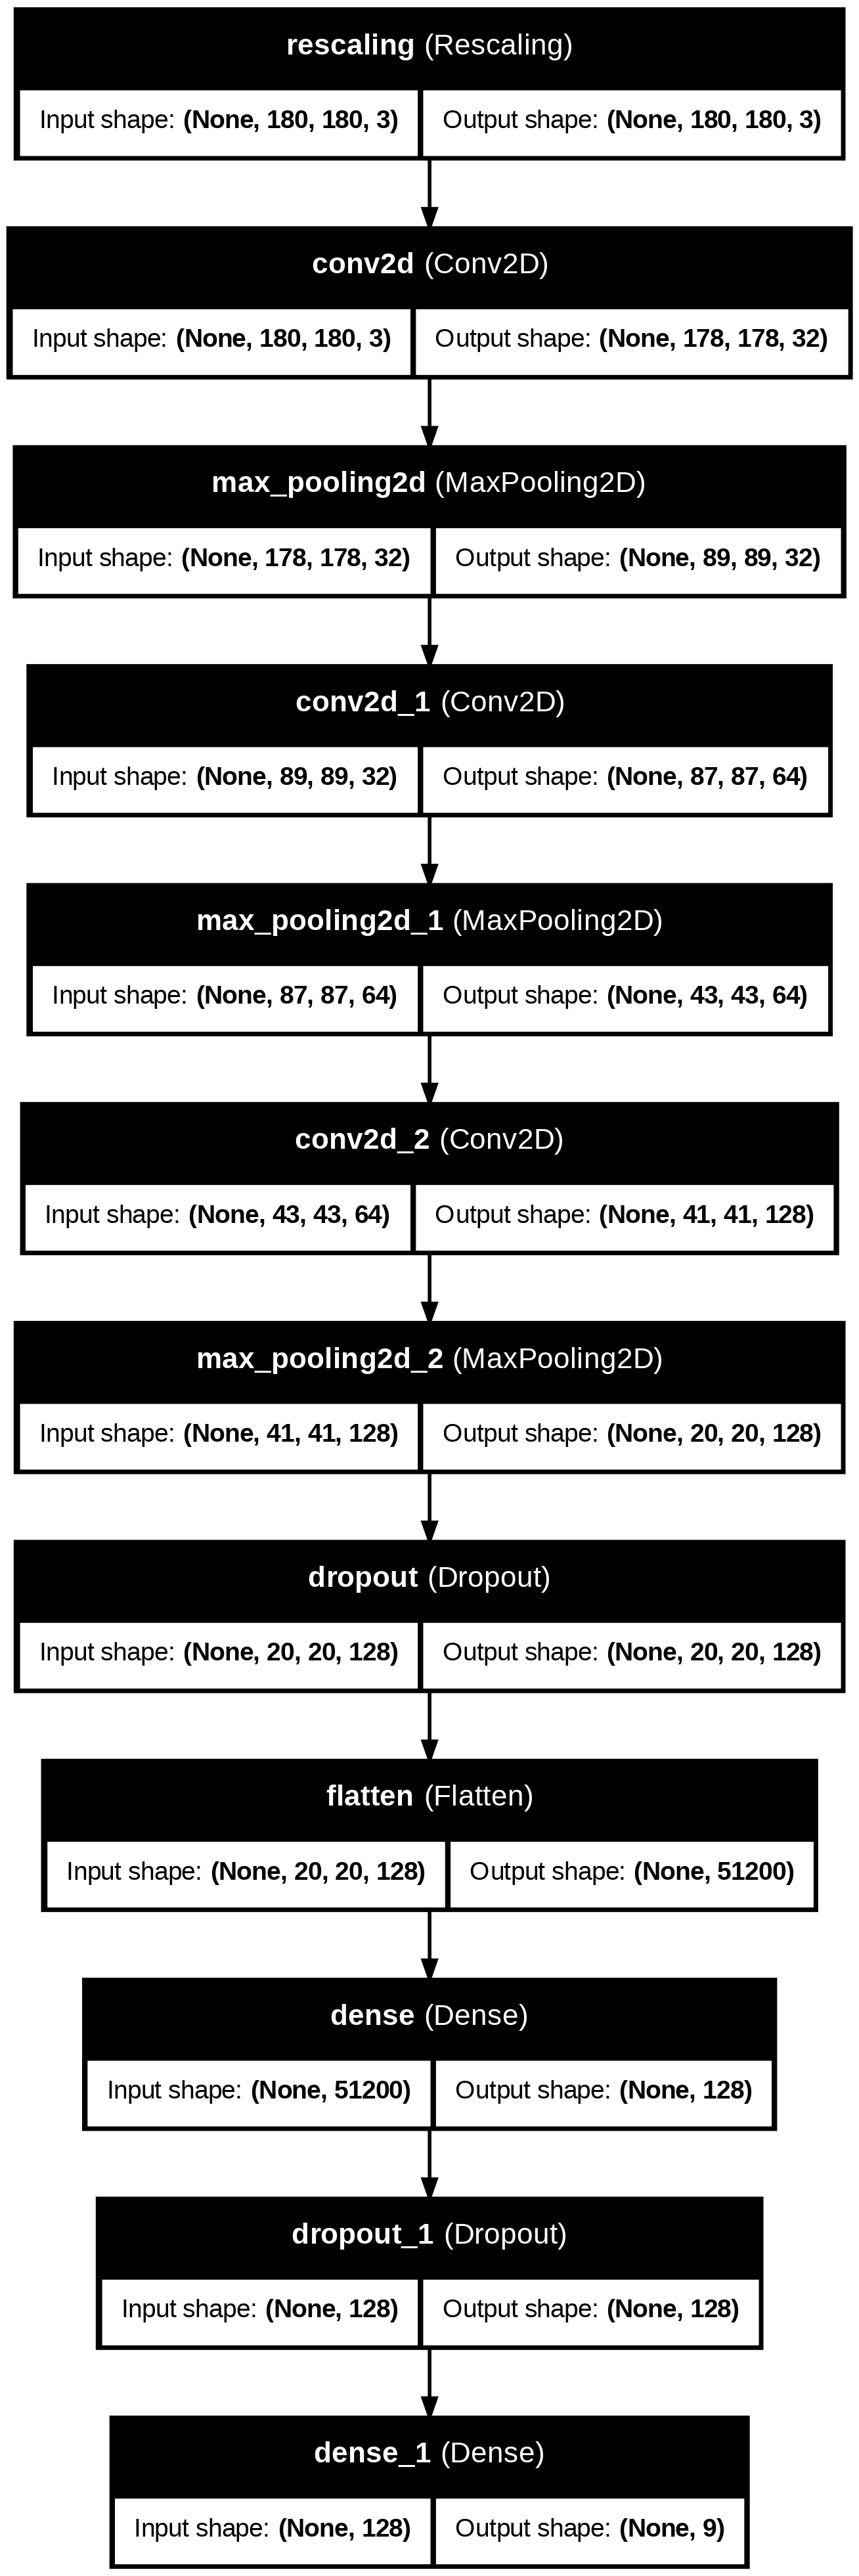

In [ ]:
# Visualize the model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
#

In [ ]:
# --- Model Compilation ---
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# --- Checkpoint: Save best model in Google Drive in .keras format ---
checkpoint = ModelCheckpoint('/content/gdrive/MyDrive/skin_cancer_model_v6.keras',  # Native Keras format
                             monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='auto')

# --- Early Stopping: Stops training if no improvement for 5 epochs ---
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

# --- Train the model ---
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=40,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/40
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2512 - loss: 1.9749
Epoch 1: val_accuracy improved from -inf to 0.44918, saving model to /content/gdrive/MyDrive/skin_cancer_model_v6.keras
326/326 ━━━━━━━━━━━━━━━━━━━━ 834s 3s/step - accuracy: 0.2514 - loss: 1.9742 - val_accuracy: 0.4492 - val_loss: 1.4210
Epoch 2/40
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4498 - loss: 1.4638
Epoch 2: val_accuracy improved from 0.44918 to 0.54661, saving model to /content/gdrive/MyDrive/skin_cancer_model_v6.keras
326/326 ━━━━━━━━━━━━━━━━━━━━ 753s 2s/step - accuracy: 0.4499 - loss: 1.4636 - val_accuracy: 0.5466 - val_loss: 1.1886
Epoch 3/40
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5281 - loss: 1.3004
Epoch 3: val_accuracy improved from 0.54661 to 0.63214, saving model to /content/gdrive/MyDrive/skin_cancer_model_v6.keras
326/326 ━━━━━━━━━━━━━━━━━━━━ 783s 2s/step - accuracy: 0.5282 - loss: 1.3001 - val_accuracy: 0.6321 - val_loss: 1.0132
Epoch 4/40
326/326 ━━━━━━

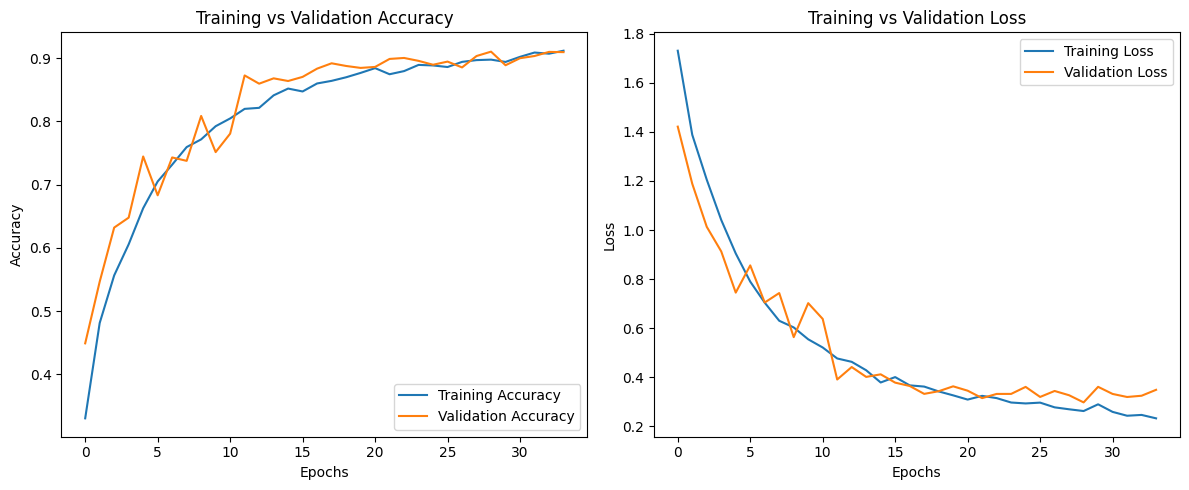

In [ ]:
# Plotting

# Extract training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))  # Ensures x-axis covers all training epochs

# Create the figure
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

##### **Prediction**

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,944,413 (76.08 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,296,276 (50.72 MB)

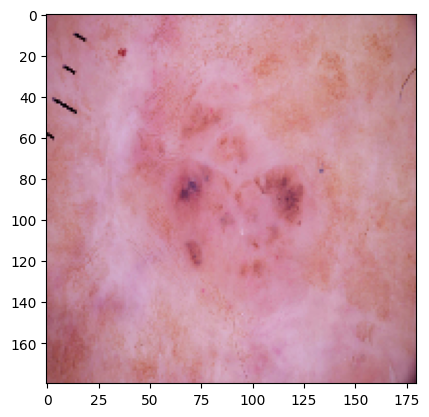

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Actual Class: basal cell carcinoma
Predicted Class: basal cell carcinoma


In [ ]:
# Load the model
model = load_model('/content/gdrive/MyDrive/skin_cancer_model_v6.keras')

# Display the model architecture
model.summary()

# Define the test image path using pathlib
test_image_path = list(Path(testing_data, class_names[1]).glob('*'))  # Get all image files in the class directory

# Ensure there is at least one image before proceeding
if test_image_path:
    test_image = load_img(test_image_path[-1], target_size=(180, 180, 3))  # Load the last image

    # Display the image
    plt.imshow(test_image)
    plt.grid(False)
    plt.show()

    # Preprocess image for model prediction
    img = np.expand_dims(test_image, axis=0)  # Expand dimensions to match model input
    pred = model.predict(img)
    pred = np.argmax(pred)  # Get the predicted class index
    pred_class = class_names[pred]  # Get the class name

    # Print actual and predicted class
    print(f"Actual Class: {class_names[1]}\nPredicted Class: {pred_class}")
else:
    print("No test images found in the specified directory.")


##### **References**

[1] Public Health Agency of Canada. (n.d.). Melanoma Skin Cancer. Retrieved 2025, from
https://www.canada.ca/en/public-health/services/chronic-diseases/cancer/melanoma-skin-
cancer.html <BR>
[2] American Cancer Society. (n.d.). What Is Melanoma Skin Cancer? Retrieved 2025, from
https://www.cancer.org/cancer/types/melanoma-skin-cancer/about/what-is-melanoma.html <BR>
[3] Skin Cancer Foundation. (n.d.). Melanoma Warning Signs. Retrieved 2025, from
https://ww